In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import time
import json
from dotenv import load_dotenv

In [2]:
from openai import OpenAI
load_dotenv()
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [3]:
user_train_path = '/home/grads/m/mbismay/llm-based-seq-rec/fashion/fashion_data/processed_data/user_train.json'
user_valid_path = '/home/grads/m/mbismay/llm-based-seq-rec/fashion/fashion_data/processed_data/user_valid.json'
user_test_path = '/home/grads/m/mbismay/llm-based-seq-rec/fashion/fashion_data/processed_data/user_test.json'

In [4]:
with open(user_train_path, 'rb') as f:
    user_train_dict = json.load(f)
with open(user_valid_path, 'rb') as f:
    user_valid_dict = json.load(f)
with open(user_test_path, 'rb') as f:
    user_test_dict = json.load(f)

In [5]:
user_id = '1'
print(user_train_dict[user_id])
print(user_valid_dict[user_id])
print(user_test_dict[user_id])

[11, 12, 13, 14, 15]
[12, 13, 14, 15, 16]
[13, 14, 15, 16, 17]


In [6]:
item_information_path = '/home/grads/m/mbismay/llm-based-seq-rec/fashion/fashion_data/processed_data/processed_item_information.json'
with open(item_information_path, 'r') as f:
    item_information_dict = json.load(f)
print(len(item_information_dict))

6089


In [7]:
ratings_path = '../../fashion_data/processed_data/ratings.csv'
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,item,user,rating,timestamp
0,0,0,4.0,1452816000
1,1,0,4.0,1453766400
2,2,0,3.0,1453766400
3,3,0,4.0,1453766400
4,4,0,4.0,1453766400


In [8]:
user_profile_summary_path = '../../fashion_data/processed_data/user_profile_summary.json'
with open(user_profile_summary_path, 'r') as f:
    user_profile_summary_dict = json.load(f)
print(len(user_profile_summary_dict), user_profile_summary_dict['1'])

848 
The user seems to prefer stylish and high-quality products, with a preference for good design and functionality. They liked the Destiny-themed wallet for its cool design and good quality, but disliked the hard-to-open button. They appreciated the spacious and sturdy backpack, but noted that it may not hold too much weight or size. The user liked the formal pencil dress for its stylish and expensive look, but found it unsuitable for pear-shaped women. Overall, the user values both style and functionality in their fashion purchases.


In [9]:
def get_item_description(item_information):
    item_details = ""
    if 'title' in item_information:
        item_details += item_information['title']
    if 'brand' in item_information:
        item_details += f" Brand: {item_information['brand']}"
    if 'price' in item_information:
        item_details += f" Price: {item_information['price']}"
    if 'description' in item_information:
        item_details += f" Description: {item_information['description']}"
    return item_details

In [10]:
### Train Data Reaosning
train_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_train_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    if user in user_profile_summary_dict:
        prompt = f"""You are an expert fashion product recommender. You are provided with a user's profile and list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it.
        User Profile - {user_profile_summary_dict[user]}
        User purchased the following items in the given order. List of recent items and their description -
        """
    else:
        prompt = """You are an expert fashion product recommender. You are provided with user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it.
        User purchased the following items in the given order. List of recent items and their description -
        """
    for item in item_list[:-1]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {item_information_dict[str(target_item)]['title']}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the user profile, list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will LIKE the next item - "{target_item_details}", in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next purchased item - {item_information_dict[str(target_item)]['title']}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the user profile, list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will DISLIKE the next purchased item - "{target_item_details}", in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    train_reasoning_prompts[user] = [prompt, recommendation]
    # break
# print(train_reasoning_prompts)

In [11]:
total_len = 0
all_prompt_lens = []
for user, prompt in train_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(train_reasoning_prompts))

1444.3079340141398


(array([  1.,   1.,   2.,   3.,   5.,   5.,  24.,  26.,  53.,  55.,  64.,
         73.,  62.,  55.,  42.,  44.,  35.,  68.,  67.,  68.,  58.,  37.,
         28.,  23.,  14.,   4.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

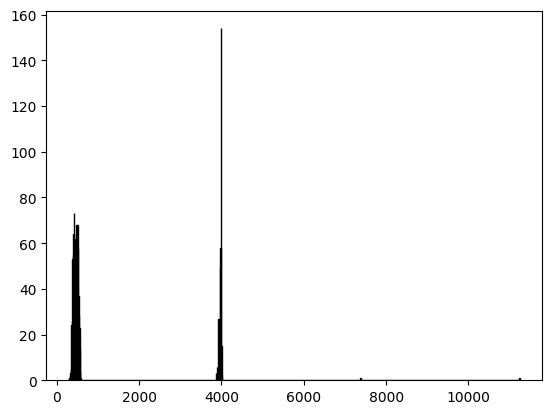

In [12]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [13]:
### Valid Data Reaosning
valid_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_valid_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    if user in user_profile_summary_dict:
        prompt = f"""You are an expert fashion product recommender. You are provided with a user's profile and list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it.
        User Profile - {user_profile_summary_dict[user]}
        User purchased the following items in the given order. List of recent items and their description -
        """
    else:
        prompt = """You are an expert fashion product recommender. You are provided with user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it.
        User purchased the following items in the given order. List of recent items and their description -
        """
    for item in item_list[:-1]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {item_information_dict[str(target_item)]['title']}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the user profile, list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will LIKE the next item - "{target_item_details}", in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next purchased item - {item_information_dict[str(target_item)]['title']}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the user profile, list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will DISLIKE the next purchased item - "{target_item_details}", in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    valid_reasoning_prompts[user] = [prompt, recommendation]
    # break
print(len(valid_reasoning_prompts))

1273


In [14]:
total_len = 0
all_prompt_lens = []
for user, prompt in valid_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(valid_reasoning_prompts))

1410.59465828751


(array([  1.,   1.,   0.,   1.,   0.,   2.,   7.,  11.,  18.,  33.,  33.,
         65.,  63.,  60.,  69.,  53.,  51.,  43.,  40.,  63.,  61.,  64.,
         66.,  42.,  41.,  20.,  17.,   6.,   1.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

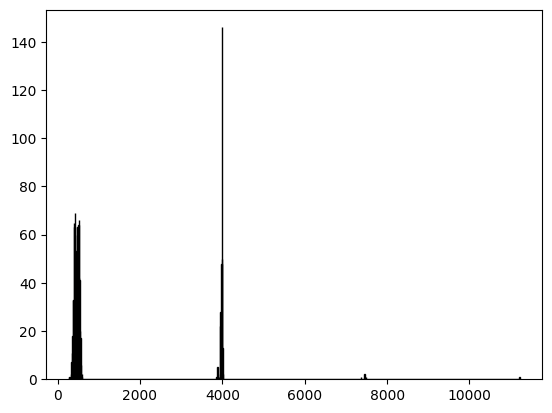

In [15]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [16]:
### Test Data Reaosning
test_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_test_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    if user in user_profile_summary_dict:
        prompt = f"""You are an expert fashion product recommender. You are provided with a user's profile and list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it.
        User Profile - {user_profile_summary_dict[user]}
        User purchased the following items in the given order. List of recent items and their description -
        """
    else:
        prompt = """You are an expert fashion product recommender. You are provided with user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it.
        User purchased the following items in the given order. List of recent items and their description -
        """
    for item in item_list[:-1]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {item_information_dict[str(target_item)]['title']}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the user profile, list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will LIKE the next item - "{target_item_details}", in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next purchased item - {item_information_dict[str(target_item)]['title']}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the user profile, list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will DISLIKE the next purchased item - "{target_item_details}", in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    test_reasoning_prompts[user] = [prompt, recommendation]
    # break
print(len(test_reasoning_prompts))

1273


In [17]:
total_len = 0
all_prompt_lens = []
for user, prompt in test_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(test_reasoning_prompts))

541.5208169677926


(array([  2.,   1.,   0.,   1.,   0.,   3.,   1.,   8.,  12.,  15.,  21.,
         22.,  25.,  37.,  42.,  43.,  52.,  47.,  39.,  46.,  40.,  20.,
         29.,  35.,  27.,  63.,  65.,  50.,  62.,  82.,  69.,  67., 149.,
         36.,  14.,   9.,  10.,   4.,   3.,   0.,   1.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

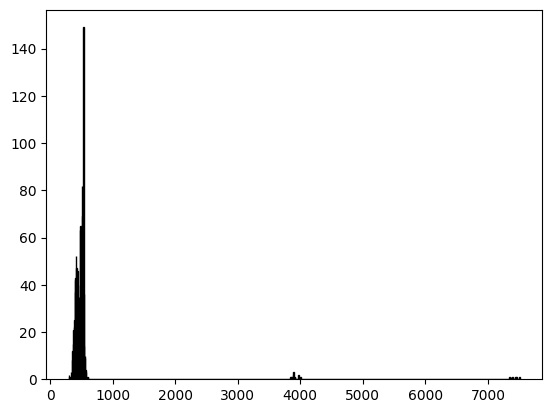

In [18]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [19]:
very_long_prompts_users = set()
len_threshold = 600
for user, prompt in test_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)
for user, prompt in train_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)
for user, prompt in valid_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)

In [20]:
very_long_prompts_users = list(very_long_prompts_users)
print(len(very_long_prompts_users))

367


In [21]:
for user in very_long_prompts_users:
    train_reasoning_prompts.pop(user, None)
    valid_reasoning_prompts.pop(user, None)
    test_reasoning_prompts.pop(user, None)
print(len(train_reasoning_prompts), len(valid_reasoning_prompts), len(test_reasoning_prompts))

906 906 906


In [22]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_train.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(train_reasoning_prompts, f)
    f.close()

In [23]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_valid.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(valid_reasoning_prompts, f)
    f.close()

In [24]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_test.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(test_reasoning_prompts, f)
    f.close()

In [25]:
user = '0'
print(train_reasoning_prompts[user])
print(valid_reasoning_prompts[user])
print(test_reasoning_prompts[user])

['You are an expert fashion product recommender. You are provided with a user\'s profile and list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it.\n        User Profile - \n\nThe user seems to prefer long-sleeved shirts and knit fabric, as indicated by their purchase of the Allegra K Lady Long Sleeve Letter Pattern Pullover Knit Shirt Black S. They appreciate a good quality fabric and length, but also value comfort and simplicity. The user disliked the product because it was too casual, suggesting they may prefer more formal or stylish clothing. The user\'s preference for leggings as a pairing item also implies they may enjoy a more fitted or form-fitting style. Overall, the user values comfort, quality, and style, with a preference for long-sleeved knit shirts and fitted styles.\n        User purchased the following items in the given order. List of recent items and their description -\n        Liked Allegra K Women Boat N

In [26]:
user = '0'
content = train_reasoning_prompts[user][0]
groundtruth = train_reasoning_prompts[user][1]
print(content)
print('*'*100)
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "user",
      "content": content
    }
  ],
  temperature=0,
  max_tokens=256,
  top_p=0.75
)


response = response.choices[0].message.content
print(response)
len(response.split(' '))

You are an expert fashion product recommender. You are provided with a user's profile and list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it.
        User Profile - 

The user seems to prefer long-sleeved shirts and knit fabric, as indicated by their purchase of the Allegra K Lady Long Sleeve Letter Pattern Pullover Knit Shirt Black S. They appreciate a good quality fabric and length, but also value comfort and simplicity. The user disliked the product because it was too casual, suggesting they may prefer more formal or stylish clothing. The user's preference for leggings as a pairing item also implies they may enjoy a more fitted or form-fitting style. Overall, the user values comfort, quality, and style, with a preference for long-sleeved knit shirts and fitted styles.
        User purchased the following items in the given order. List of recent items and their description -
        Liked Allegra K Women Boat Neck Batwi

122